# Advanced Machine Learning Project - Image Super-Resolution

In [1]:
# Imports
from google.colab import drive
import zipfile
import shutil
from skimage import io
import os

from matplotlib import pyplot as plt
import numpy as np
import cv2
import math

import random as python_random
import tensorflow as tf
from tensorflow import keras

np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)
keras.utils.set_random_seed(0)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Link Google Drive account, transfer dataset, and extract files
shutil.copy('/content/drive/My Drive/ImageSuperResolutionDataset.zip', 'ImageSuperResolutionDataset.zip')
zipf = zipfile.ZipFile('ImageSuperResolutionDataset.zip')
zipf.extractall()
zipf.close()

os.remove('ImageSuperResolutionDataset.zip') # Delete the copied zip file

### split_image function

This function takes as input an image and the target size of the returned images.

The goal is to split each image that is bigger than the target size into smaller images of the size target_size, by spreading the crops evenly across the original image.

This will be first used to augment the dataset, and then it will be used to generate even bigger images later (probably???).

In [2]:
def split_image(image, target_size=(1000, 1000)):
    h, w, _ = image.shape
    target_h, target_w = target_size
    #print(w, h)

    # If the image is smaller than the target size, discard the image
    if h <= target_h or w <= target_w:
        #print(f"The image size ({h}, {w}) is smaller than the target size ({target_h}, {target_w}), discarding image.")
        return None

    cropped_images = [] # List to store the cropped images

    # Calculates the amount of images per axis
    tot_images_x = math.ceil(w/target_w)
    tot_images_y = math.ceil(h/target_h)

    # Calculates the amount of sliding per axis, so that each cropped image is as far as possible to the others and the amount of overlappings are equally distributed
    slide_w=int(w/tot_images_x)
    slide_h=int(h/tot_images_y)


    for j in range(tot_images_y):
        for i in range(tot_images_x):
            start_w = slide_w * i
            start_h = slide_h * j
            if(start_w + target_w > w):
                start_w = w-target_w
            if(start_h + target_h > h):
                start_h = h - target_h

            end_w = start_w + target_w
            end_h = start_h + target_h
            #print(start_w, end_w, start_h, end_h)

            cropped = image[start_h:end_h, start_w:end_w]
            #print("shape:", cropped.shape)
            cropped_images.append(cropped)

    # Converts the list of cropped images to a NumPy array
    return np.array(cropped_images)


### Example of split_image()

In the first example, the image is too small

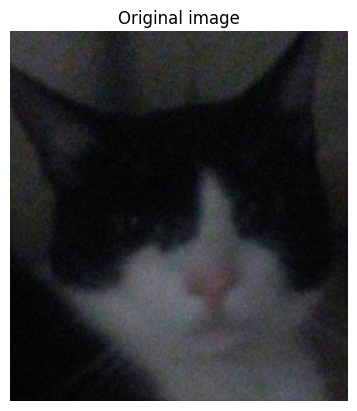

In [30]:
example_image = io.imread('/content/drive/My Drive/cat2.jpg')

plt.imshow(example_image)
plt.title("Original image")
plt.axis('off')
plt.show()

In [31]:
example_image.shape

(512, 468, 3)

In [32]:
example_images = split_image(example_image)
if(example_images is not None):
    print("Shape of segments array:", example_images.shape)

In the second example, the image is split in 4

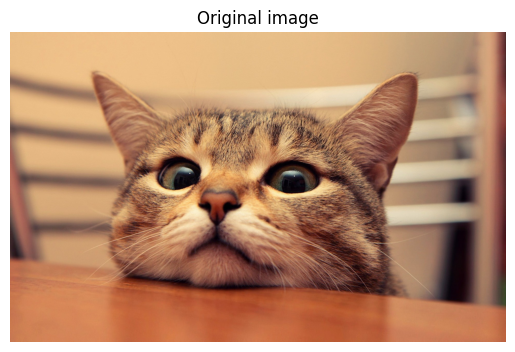

In [33]:
example_image = io.imread('/content/drive/My Drive/cat.jpg')

plt.imshow(example_image)
plt.title("Original image")
plt.axis('off')
plt.show()

In [34]:
example_image.shape

(1200, 1920, 3)

In [35]:
example_images = split_image(example_image)
if(example_images is not None):
    print("Shape of segments array:", example_images.shape)

Shape of segments array: (4, 1000, 1000, 3)


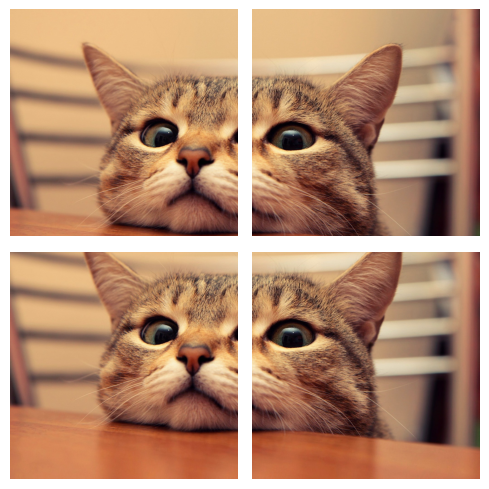

In [36]:
# Plot the 4 split images
fig, axes = plt.subplots(2, 2, figsize=(5, 5))

# Plot each image in a subplot
axes[0, 0].imshow(example_images[0])
axes[0, 0].axis('off')  # Turn off axis ticks and labels
axes[0, 1].imshow(example_images[1])
axes[0, 1].axis('off')
axes[1, 0].imshow(example_images[2])
axes[1, 0].axis('off')
axes[1, 1].imshow(example_images[3])
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

In the third example, the image is split in 12. This shows the flexibility of the function.

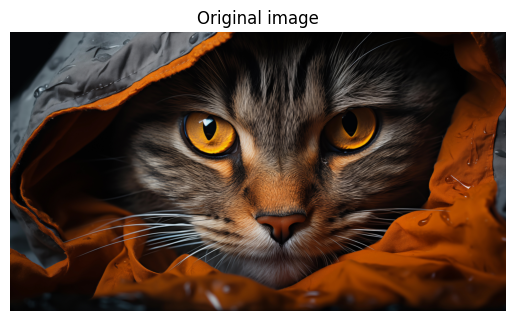

In [37]:
example_image = io.imread('/content/drive/My Drive/high_res_cat.jpg')

plt.imshow(example_image)
plt.title("Original image")
plt.axis('off')
plt.show()

In [38]:
example_image.shape

(2160, 3840, 3)

In [39]:
example_images = split_image(example_image)
if(example_images is not None):
    print("Shape of segments array:", example_images.shape)

Shape of segments array: (12, 1000, 1000, 3)


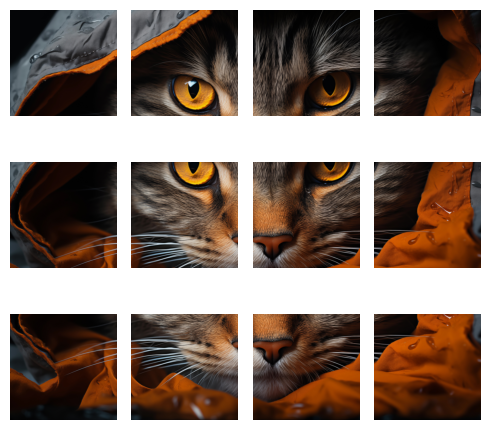

In [40]:
# Plot the 12 split images
fig, axes = plt.subplots(3, 4, figsize=(5, 5))

axes = axes.flatten()

# Plot each image in a subplot
for i in range(len(example_images)):  # Loop through all 12 images
    axes[i].imshow(example_images[i])
    axes[i].axis('off')  # Turn off axis ticks and labels

plt.tight_layout()
plt.show()

### Dataset import and augmentation

In [41]:
def import_images(folder_path, num_images, start_index=0, max_index=None):
    images_set = []  # Initialize the array as a list
    image_count = 0  # Counter for imported images
    if max_index is None:
        max_index = len(os.listdir(folder_path))

    for i in range(start_index, max_index):
        filename = os.listdir(folder_path)[i]
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            if image_count < num_images:
                image_path = os.path.join(folder_path, filename)
                #print("Importing", filename)
                image = io.imread(image_path)
                images_set.append(image / 255.0)  # Append the image to the array
                image_count += 1  # Update the image count
            else:
                break

    return images_set, start_index + image_count  # Return the images and the next start index

In [42]:
def augment_images(images, target_size=(1000, 1000)):
    augmented_images_list = []  # Initialize an empty list

    for image in images:
        split_images = split_image(image, target_size)  # Call split_image for augmentation
        if split_images is not None:
            augmented_images_list.extend(split_images)  # Append split images to the list

    return augmented_images_list

In [43]:
# Imports the first 10 train images
train_index = 0
imported_images, train_index = import_images("ImageSuperResolutionDataset/training", 10, train_index)

train_set = augment_images(imported_images) # Aguments the imported images by using the split_image function

print("Number of images in the training set:", len(train_set))
print("Shapes of individual images:", train_set[0].shape)
#print(train_index)

Number of images in the training set: 60
Shapes of individual images: (1000, 1000, 3)


In [44]:
# Calculates the train/test split
tot_images_in_dataset = len(os.listdir("ImageSuperResolutionDataset/training"))
train_index_max = int(tot_images_in_dataset * 0.75) # 75/25 train/test split
print(train_index_max) # The first 'train_index_max' images are used for training

375


In [45]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import random
import gc  # Garbage collector module

# Step 1: Define the function to provide data
def fetch_batch_data(batch_size):
    global train_index
    global train_index_max
    global train_set

    # Ensure train_set is always manageable in size
    while len(train_set) < batch_size:
        #print("Train index", train_index)
        if train_index == train_index_max:  # Reset train_index if at the end
            train_index = 0

        imported_images, train_index = import_images(
            "ImageSuperResolutionDataset/training",
            10,
            train_index,
            train_index_max
        )
        augmented_images = augment_images(imported_images)
        train_set.extend(augmented_images)

    # Randomly shuffle the train_set to select the batch
    random.shuffle(train_set)

    # Keep only the first `batch_size` images as the batch
    batch_set = train_set[:batch_size]
    #print("Batch set length", len(batch_set))

    # Update train_set to only contain the remaining images for future batches
    train_set = train_set[batch_size:]
    #print("Train set length after batch: ", len(train_set))

    # Generate random labels for the batch
    batch_labels = [random.randint(0, 1) for _ in range(batch_size)]
    #print("Batch labels length: ", len(batch_labels))

    # Explicitly clear memory
    gc.collect()

    return batch_set, batch_labels

# Step 2: Create a generator to yield batches
def data_generator(batch_size):
    while True:
        batch_images, batch_labels = fetch_batch_data(batch_size)

        # Convert lists to NumPy arrays
        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)

        gc.collect()

        yield batch_images, batch_labels

# Step 3: Define a simple model
model = models.Sequential([
    # First Convolutional Layer
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(1000, 1000, 3)),
    layers.MaxPooling2D((2, 2)),  # Max pooling to reduce spatial dimensions
    layers.MaxPooling2D((2, 2)),  # Max pooling to reduce spatial dimensions

    # Second Convolutional Layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional Layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.MaxPooling2D((2, 2)),
    layers.MaxPooling2D((3, 3)),

    # Fourth Convolutional Layer (adding more pooling)
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten the output for the fully connected layer
    layers.Flatten(),

    # Fully Connected Layer with fewer neurons
    layers.Dense(32, activation='relu'),

    # Output Layer
    layers.Dense(1, activation='sigmoid')  # Assuming 10 classes
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Step 4: Train the model with the generator
batch_size = 16
steps_per_epoch = 25  # Number of batches per epoch

history = model.fit(
    data_generator(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=10
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 998, 998, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 499, 499, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 249, 249, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 247, 247, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 123, 123, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 61, 61, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 59, 59, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 29, 29, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 2, 2, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,673 (96.38 KB)

 Trainable params: 24,673 (96.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
 2/25 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accuracy: 0.3438 - loss: 0.7012Train index 10
 6/25 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3833 - loss: 0.7017Train index 20
10/25 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4023 - loss: 0.7003Train index 30
13/25 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4094 - loss: 0.6996Train index 40
17/25 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4119 - loss: 0.6990Train index 50
21/25 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4164 - loss: 0.6984Train index 60
24/25 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4212 - loss: 0.6981Train index 70
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.4240 - loss: 0.6979
Epoch 2/10
 3/25 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5556 - loss: 0.6881Train index 80
 7/25 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5424 - loss: 0.6899Train index 90
10/25 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5374 - loss: 0.6905Train index 100
13/25 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/

In [46]:
def plot_training_metrics(history):
    # Create a figure with two subplots
    plt.figure(figsize=(12, 5))

    # Plot Training vs Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training vs Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show the plot
    plt.show()

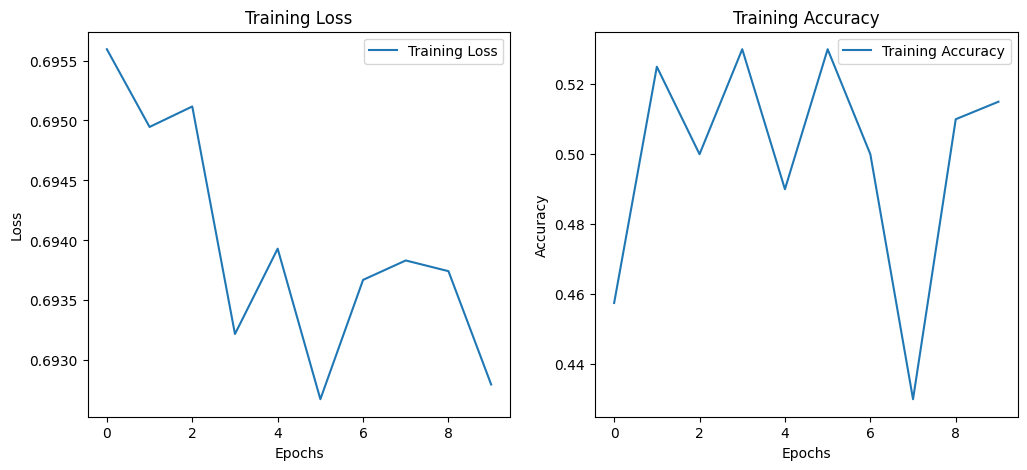

In [47]:
gc.collect()
plot_training_metrics(history)